# Conditional pix2pix GAN
### Adapted from [ericklindernoren](https://github.com/eriklindernoren/Keras-GAN/blob/master/pix2pix/pix2pix.py)
### [pix2pix paper](https://arxiv.org/pdf/1611.07004.pdf)

## TODO:
1. Set up a github repository.
2. Write a log file for each run that includes the date, name of experiment, details of parameter values, and metrics after each epoch (loss, time, etc.). This is particularly important since it is apparently impossible to see output from a Jupyter notebook if connection to the server is ever lost while it's running.
3. Output should be both displayed in the notebook and saved to a folder and should include:
  - Loss curves (should get overwritten in the output folder after each epoch, so just one image)
  - Example outputs: for several training images, show several generated images (different noise inputs). Also show generated examples for test set examples to give a feel for generalization/overfitting.
4. Make a new synthetic dataset with random number of circles (say 1-5) per image, each of which is a random color (choose from among several color options). Use LAB colorspace to generate the circles to ensure that all circles have the same L value before converting to RGB to save.
5. Consider if a different "real" data set (e.g., hotel interiors) would be better than the current set of color images to show multimodality.
6. Prediction: the GAN will learn to ignore noise input, so that generated images look similar for a given conditional input (L channel) even with different noise.
7. Try to increase diversity by generating a set number of possible outputs (i.e., more channels); check out this paper: [Photographic Image Synthesis with Cascaded Refinement Networks](https://arxiv.org/pdf/1707.09405.pdf).
8. Think about evaluation metrics, user study?
9. Potential final comparisons for paper:
  - U-NET with L2 loss (i.e., just the generator with no GAN, no noise)
  - GAN with no noise
  - GAN with noise
  - GAN with diversity improvement


In [1]:
import time

time_start = time.time()

def sec_to_time(seconds):
    days = seconds // (60 * 60 * 24)
    seconds -= days * (60 * 60 * 24)
    hours = seconds // (60 * 60)
    seconds -= hours * (60 * 60)
    minutes = seconds // 60
    seconds -= minutes * 60
    return f"{int(days)}:{int(hours):02}:{int(minutes):02}:{int(seconds):02}"

In [2]:
from __future__ import print_function, division

from keras.layers import Input, Dense, Flatten, Dropout, Reshape, Concatenate
from keras.layers import BatchNormalization, Activation, Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.optimizers import Adam

from keras.datasets import cifar10
import keras.backend as K

import matplotlib.pyplot as plt
import os
import sys
import numpy as np

%pylab inline

from PIL import Image
from tqdm import tnrange, tqdm_notebook, tqdm
import cv2
import random

import tensorflow as tf

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [3]:
def list_image_files(directory):
    files = sorted(os.listdir(directory))
    return [os.path.join(directory, f) for f in files if is_an_image_file(f)]

def is_an_image_file(filename):
    IMAGE_EXTENSIONS = ['.png', '.jpg', '.jpeg']
    for ext in IMAGE_EXTENSIONS:
        if ext in filename:
            return True
    return False

In [4]:
def load_image(path):
    img = cv2.imread(path[0])
    
    # Make sure all images are 256 x 256 by cropping them
    r, c = img.shape[:2]
    r_diff = (r - 256) // 2
    c_diff = (c - 256) // 2
    cropped = img[r_diff:256 + r_diff, c_diff:256 + c_diff] 
    return cropped

def load_images(path, n_images):
    if n_images < 0:
        n_images = float("inf")
    all_image_paths = list_image_files(path)
    images_l, images_ab = [], []
    
    # Initialize a progress bar with max of n_images
    pbar = tqdm_notebook(total = n_images, desc="Loading Images...")
    
    for path in zip(all_image_paths):
        img = load_image(path)
        lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        lab_img = preprocess_image(lab_img)
        
        l = lab_img[:,:,0]
        l = l[:,:,np.newaxis]
        # Include all 3 channels, overwrite 1st channel with 0's
        ab = lab_img[:,:,1:]

        images_l.append(l)
        images_ab.append(ab)

        images_loaded = len(images_l)
        
        # Increase progress by one
        pbar.update(1)
        
        if images_loaded > n_images - 1: 
            break

    return {
        'l': np.array(images_l),
        'ab': np.array(images_ab)
    }

In [5]:
RESHAPE = (256,256)

def preprocess_image(cv_img):
    img = (cv_img - 127.5) / 127.5
    return img

def deprocess_image(img):
    img = (img * 127.5) + 127.5
    return img.astype('uint8')

In [6]:
def save_image(np_arr, path):
    img = np_arr * 127.5 + 127.5
    im = Image.fromarray(img)
    im.save(path)

In [7]:
def sample_images(truth, gray, predicted, n_to_sample, shouldSave, sample_title):
    predicted = predicted.astype(np.float64)
    
    grays_merged = []
    truth_merged = []
    predicted_merged = []
    for i in range(n_to_sample):
#         newImageIndex = i * 2
        grays_merged.append(cv2.merge((gray[i], gray[i], gray[i])))
        truth_merged.append(cv2.merge((gray[i], truth[i])))
        predicted_merged.append(cv2.merge((gray[i], predicted[i])))
    
    r = truth.shape[1]
    c = truth.shape[2]

    figure = np.zeros([r * n_to_sample + 15 * (n_to_sample-1), c * 3 + 5 * (3-1), 3], dtype=np.uint8)
    figure += 255
    start_r = 0
    
    for i in range(n_to_sample):        
        figure[start_r:start_r + r, :c] = cv2.cvtColor(deprocess_image(truth_merged[i]), cv2.COLOR_LAB2RGB)
        figure[start_r:start_r + r, c + 5:2*(c)+5] = deprocess_image(grays_merged[i])
        figure[start_r:start_r + r, 2*(c+5):3*c + 5*2] = cv2.cvtColor(deprocess_image(predicted_merged[i]), cv2.COLOR_LAB2RGB)
        start_r += r + 15
    img = Image.fromarray(figure, "RGB")
    
    dpi = plt.rcParams['figure.dpi']
    height, width, _ = figure.shape

    preview = plt.figure(figsize=(6,4))
    plt.imshow(img)
    plt.axis("off")
    plt.title(sample_title, fontsize = 'large')
    
    plt.show()
    
    if shouldSave:
        # What size does the figure need to be in inches to fit the image?
        figsize = width / float(dpi), height / float(dpi)
        
        full = plt.figure(figsize = figsize)
        plt.imshow(img)
        plt.axis("off")
        plt.title(sample_title, fontsize = 25)
        plt.savefig(save_path + sample_title + ".png")
        plt.close()

In [8]:
def sample_imgs_new(truth, gray, predictions, n_test_batch, shouldSave, sample_title=None):    
    # Store all merged
    merged_predictions = []
    merged_grays = []
    merged_truths = []
        
    # For each image...
    for i in range(n_test_batch):
        # Get prediction, merge
        merged = []
        # For each k...
        for j in range(k):
            # Generate a prediction...
            prediction = predictions[i,:,:,2*j:(2*j)+2].astype(np.float64)
            # And merge it to be a 3 channel image
            merged.append(cv2.merge((gray[i], prediction)))
        merged_predictions.append(merged) 
        
        # Merge the grayscale channels
        merged_grays.append(cv2.merge((gray[i], gray[i], gray[i])))
        
        # Merge the l and ab to create truth
        merged_truths.append(cv2.merge((gray[i], truth[i])))

    
    r = truth.shape[1]
    c = truth.shape[2]
    
    start_r = 0

    n_predictions = k
    # Create figure
    columns = 2 + n_predictions
    figure = np.zeros([r * n_test_batch + (15 * (n_test_batch-1)), (c * columns) + 5 * (columns-1), 3], dtype=np.uint8)
    figure += 255
    
    # Loop through sets of test images
    for i in range(n_test_batch):
        # Place truth and gray
        figure[start_r:start_r + r, :c] = cv2.cvtColor(deprocess_image(merged_truths[i]), cv2.COLOR_LAB2RGB)
        figure[start_r:start_r + r, c + 5:2*c + 5] = deprocess_image(merged_grays[i])

        # Place multiple preditions in figure
        for j in range(n_predictions):  
            current_predictions = merged_predictions[i]
            figure[start_r:start_r + r, (2+j)*(c+5):(3+j)*c + (5*(2+j))] = \
                cv2.cvtColor(deprocess_image(current_predictions[j]), cv2.COLOR_LAB2RGB)
        start_r += r + 15
    img = Image.fromarray(figure, "RGB")

    dpi = plt.rcParams['figure.dpi']
    height, width, _ = figure.shape

    preview = plt.figure(figsize=(6,4))
    plt.imshow(img)
    plt.axis("off")
    title = sample_title
    plt.title(title, fontsize = 'large')
    plt.show()

    if shouldSave:
        # What size does the figure need to be in inches to fit the image?
        figsize = width / float(dpi), height / float(dpi)

        full = plt.figure(figsize = figsize)
        plt.imshow(img)
        plt.axis("off")
        plt.title(title, fontsize = 25)
        plt.savefig(save_path + sample_title + ".png")
        plt.close()

In [9]:
def get_generator(H, W, k):
    # Inputs: height and width of the input image
    # Returns the model, which generates the AB channels

    # Pix2pix adapted from 
    # https://github.com/eriklindernoren/Keras-GAN/blob/master/pix2pix/pix2pix.py

    def conv2d(layer_input, filters, f_size=4, bn=True):
        """Layers used during downsampling"""
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if bn:
            d = BatchNormalization(momentum=0.8)(d)
        return d

    def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
        """Layers used during upsampling"""
        u = UpSampling2D(size=2)(layer_input)
        u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
        if dropout_rate:
            u = Dropout(dropout_rate)(u)
        u = BatchNormalization(momentum=0.8)(u)
        u = Concatenate()([u, skip_input])
        return u

    gf = 64 # Number of filters in the first layer of G

    noise_in = Input(shape=(100,))
    condition_in = Input(shape=(H, W, 1))
    
    # pass noise through a FC layer to get it to the right size
    noise = Dense(H * H)(noise_in)

    # reshape to be the size of an image channel
    noise = Reshape((H, H, 1))(noise)
    
    # stick the (somewhat modified) noise as the second channel after
    # the gray input. Assuming new dimension of hid will be
    # B x 256 x 256 x 2, where B is the batch size.
#     d0 = Concatenate(axis=-1)([condition_in, noise])
    d0 = condition_in # Don't need noise since it's being ignored anyway

    # U-NET
    # Downsampling
    d1 = conv2d(d0, gf, bn=False)
    d2 = conv2d(d1, gf*2)
    d3 = conv2d(d2, gf*4)
    d4 = conv2d(d3, gf*8)
    d5 = conv2d(d4, gf*8)
    d6 = conv2d(d5, gf*8)
    d7 = conv2d(d6, gf*8)

    # Upsampling
    u1 = deconv2d(d7, d6, gf*8)
    u2 = deconv2d(u1, d5, gf*8)
    u3 = deconv2d(u2, d4, gf*8)
    u4 = deconv2d(u3, d3, gf*4)
    u5 = deconv2d(u4, d2, gf*2)
    u6 = deconv2d(u5, d1, gf)

    u7 = UpSampling2D(size=2)(u6)
    
    # Final 2-channel AB image with values between -1 and 1
    img_out = Conv2D(2*k, kernel_size=4, strides=1, padding='same', activation='tanh', name='pred_ab')(u7)

    # Make Model
    model = Model(inputs=[noise_in, condition_in], outputs=img_out)
    
    # Show summary of layers
    print("Generator Model:")
    model.summary()

    return model


In [ ]:
def get_discriminator(H, W, k):
    # Inputs: height and width of the input image
    # Returns the model, which predicts real/fake
    # over a set of spatial regions (i.e., predicts a matrix instead of a scalar).

    # Pix2pix adapted from 
    # https://github.com/eriklindernoren/Keras-GAN/blob/master/pix2pix/pix2pix.py

    def d_layer(layer_input, filters, f_size=4, bn=True):
        """Discriminator layer"""
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if bn:
            d = BatchNormalization(momentum=0.8)(d)
        return d

    # Number of filters in the first layer of D
    df = 64

    img_in = Input(shape=(H, W, 2*k)) # AB channels
    condition_in = Input(shape=(H, W, 1)) # L channel
    
    # Concat the L and AB channels
    concat_imgs = Concatenate()([condition_in, img_in])

    d1 = d_layer(concat_imgs, df, bn=False)
    d2 = d_layer(d1, df*2)
    d3 = d_layer(d2, df*4)
    d4 = d_layer(d3, df*8)

    # validity map is a one-channel matrix 1/16 the size of the input (halved 4 times).
    # Each number predicts whether a region of the input is real/fake.
    validity = Conv2D(1*k, kernel_size=4, strides=1, padding='same', name='pred_valid')(d4)

    # Build Model
    model = Model(inputs=[img_in, condition_in], outputs=validity)

    # Show summary of layers
    print("Disciminator Model:")
    model.summary()

    return model


In [ ]:
def min_k_gen_loss(y_true, y_pred):
    y_true = K.reshape(y_true, (-1, H, W, k, 2))
    y_pred = K.reshape(y_pred, (-1, H, W, k, 2))

    print("true:", y_true.shape)
    print("pred:", y_pred.shape)

    diff = y_true - y_pred
    diff = K.abs(diff)
    diff = K.mean(diff, axis=(1, 2, 4))
    std_dev = K.std(y_pred, axis=(1, 2, 4))
    
    loss_metric = diff - (0.005 * std_dev)
    min_for_each_batch = K.min(loss_metric, axis=1)
    return K.sum(min_for_each_batch)
    
#     print("current size:", diff.shape)
#     best_k = K.argmin(diff, axis=1)
#     print("best_k:", best_k)
#     batch_range = K.arange(BATCH_SIZE, dtype='int64')
#     print("batch_range:", batch_range)
#     print("shapes:", batch_range.shape, best_k.shape)
    
#     batch_range = K.reshape(batch_range, (BATCH_SIZE, 1))
#     best_k = K.reshape(best_k, (BATCH_SIZE, 1))

#     idx = K.concatenate((batch_range, best_k), axis=1)
#     print(idx.shape)
    
#     min_for_each_n = tf.gather_nd(diff, idx)
#     std_dev_for_each_n = tf.gather_nd(std_dev, idx)
#     print("current min_for_each_n size:", min_for_each_n.shape)
#     print("current std_dev_for_each_n size:", std_dev_for_each_n.shape)

#     return K.sum(min_for_each_n) - (.005 * K.sum(std_dev_for_each_n))

In [ ]:
from keras.preprocessing import image

def generate_noise(n_samples, noise_dim):
    X = np.random.normal(0, 1, size=(n_samples, noise_dim))
    return X

def show_samples(batchidx, save_path):
    fig, axs = plt.subplots(5, 6, figsize=(10,6))
    plt.subplots_adjust(hspace=0.3, wspace=0.1)
    #fig, axs = plt.subplots(5, 6)
    #fig.tight_layout()
    for classlabel in range(10):
        row = int(classlabel / 2)
        coloffset = (classlabel % 2) * 3
        lbls = one_hot_encode([classlabel] * 3)
        noise = generate_noise(3, 100)
        gen_imgs = generator.predict([noise, lbls])

        for i in range(3):
            # Dont scale the images back, let keras handle it
            img = image.array_to_img(gen_imgs[i], scale=True)
            axs[row,i+coloffset].imshow(img)
            axs[row,i+coloffset].axis('off')
            if i ==1:
                axs[row,i+coloffset].set_title(tags[classlabel])
    plt.savefig(save_path + '.jpg')
    plt.show()
    plt.close()

In [ ]:
def plot_losses(g_losses, d_losses, epoch_num):
    # Scale axis so it lines up with epoch_num
    x_axis = [epoch_num * x / (len(g_losses) - 1) for x in range(len(g_losses))]
    
    ax = subplot(1,1,1)
    ax.plot(x_axis, g_losses, label="Generator")
    ax.plot(x_axis, d_losses, label="Discriminator")
    plt.title("Losses After " + str(epoch_num) + " Epochs")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    plt.savefig(save_path + "Losses.jpg")
    plt.show()

## Parameters

In [ ]:
test_name = "pix2pix_multimodal_new_loss_tweaked_LSUN_10k"

n_images = 5000    # Number of images to load for training; recommended = 512
BATCH_SIZE = 6
N_EPOCHS = 100

# dataset = 'new_circles/'
dataset = 'lsun/'
# dataset = '../Colorization_GAN/circle_pairs/'


k = 10 # Number of modes

In [ ]:
# Create folder to store output
generic_output_folder = "Output/"
new_output_folder = test_name + "/"
save_path = generic_output_folder + new_output_folder

# Ensure output can save in desired location
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [ ]:
# Get training images
# Load dataset, convert to LAB, normalize to range [-1, 1]
data = load_images(dataset + 'train', n_images)

# Separate into inputs (X) and outputs (Y)
y_train, X_train = data['ab'], data['l']

num_batches = X_train.shape[0] // BATCH_SIZE


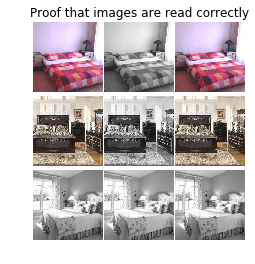

In [ ]:
sample_images(y_train, X_train, y_train, 3, False, "Proof that images are read correctly")

In [ ]:
# GAN creation
H = W = 256

# Discriminator loss - MSE seems to produce better results
#discrim_loss = 'binary_crossentropy'
discrim_loss = 'mse'

# 1. Discriminator
# Calculate output shape of D (PatchGAN)
patch = H // 2**4 # Input size gets cut in half 4 times
discriminator = get_discriminator(H, W, k)
discriminator.name = 'discrim_model' # Need a name for the loss dictionary below
discriminator.compile(optimizer=Adam(2e-4, 0.5), loss=discrim_loss, metrics=['accuracy'])
discriminator.trainable = False # For the combined model we will only train the generator
print("\n")

# 2. Generator
generator = get_generator(H, W, k)
generator.name = 'gen_model' # Need a name for the loss dictionary below

# 3. GAN
gan_noise_in = Input(shape=(100,))
gan_condition_in = Input(shape=(H, W, 1))

# By conditioning on L generate a fake version of AB
fake_AB = generator([gan_noise_in, gan_condition_in])

# Discriminator determines validity of AB images / L pairs
print("fake_ab:", fake_AB.shape)

print("gan_condition_in:", gan_condition_in.shape)

valid = discriminator([fake_AB, gan_condition_in])

losses = {'gen_model': min_k_gen_loss, # used to be 'mae'
          'discrim_model': discrim_loss}
loss_weights = {'gen_model': 100.0, 'discrim_model': 1.0}

gan = Model(inputs=[gan_noise_in, gan_condition_in], outputs=[fake_AB, valid])
gan.compile(optimizer=Adam(2e-4, 0.5), loss=losses, loss_weights=loss_weights)
gan.summary()

Disciminator Model:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 256, 256, 20) 0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 256, 256, 21) 0           input_2[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 21568       concatenate_1[0][0]     

fake_ab: (?, 256, 256, 20)
gan_condition_in: (?, 256, 256, 1)
true: (?, 256, 256, 10, 2)
pred: (?, 256, 256, 10, 2)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
gen_model (Model)               (None, 256, 256, 20) 41876116    input_5[0][0]                    
                                                                 input_6[0][0]                    
____________________________________________________________________________________________

/home/drew/anaconda3/envs/tf/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 0001, Gen Loss: 51.4805, Discrim Loss: 0.1152, Discrim Acc: 0.1060


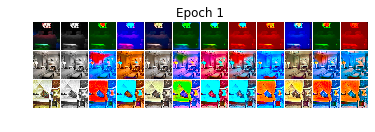

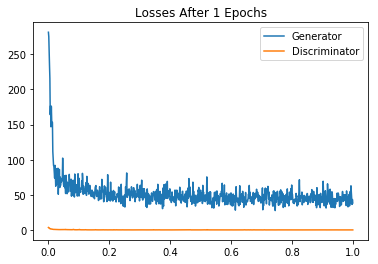

In [ ]:

g_losses = []
d_losses = []
d_accuracies = []

# PatchGAN loss ground truths
true_labels = np.ones((BATCH_SIZE, patch, patch, k))
fake_labels = np.zeros((BATCH_SIZE, patch, patch, k))

for epoch in tqdm_notebook(range(N_EPOCHS), desc="Training GAN..."):

    cum_d_loss = 0.
    cum_g_loss = 0.
    cum_d_acc = 0.

    pbar_message = "Epoch " + str(epoch + 1)
    for batch_idx in tqdm_notebook(range(num_batches), desc=pbar_message):
        # Random indices for training examples
        idx = randint(0, y_train.shape[0], BATCH_SIZE)

        # X is L channel, Y is AB
        # Get the next set of real images to be used in this iteration
        ab_channel = y_train[idx]
        ab_vis = ab_channel.copy()
        
        ab_channel = np.expand_dims(ab_channel, axis=3)
        ab_channel = np.repeat(ab_channel, k, axis=3) # repeat along the newly created k axis
        ab_channel = np.reshape(ab_channel, (-1, H, W, 2*k)) # stack the channels so things are the right shape
        
        # Get the next set of labels (grayscale images to be used in this iteration)
        l_channel = X_train[idx]

        noise_data = generate_noise(BATCH_SIZE, 100)

        # Generate fake AB channels from L
        fake_ab = generator.predict([noise_data, l_channel])

        # Train discriminator on fake and real data
        d_loss_fake, d_acc_fake = discriminator.train_on_batch([fake_ab, l_channel], fake_labels)
        d_loss_true, d_acc_true = discriminator.train_on_batch([ab_channel, l_channel], true_labels)
        d_loss = (d_loss_fake + d_loss_true) / 2
        d_acc = (d_acc_fake + d_acc_true) / 2
        
        cum_d_loss += d_loss
        cum_d_acc += d_acc

        # Train generator (by way of the whole gan)
        # Note that there are 3 losses. The first should be the
        # weighted sum of the adversarial and L1 loss values for the batch.
        # Ref: https://machinelearningmastery.com/how-to-implement-pix2pix-gan-models-from-scratch-with-keras/
        g_loss, _, _ = gan.train_on_batch([noise_data, l_channel], [ab_channel, true_labels])
        cum_g_loss += g_loss

        g_losses.append(g_loss)
        d_losses.append(d_loss)
        d_accuracies.append(d_acc)

    print('Epoch: {:04d}, Gen Loss: {:0.4f}, Discrim Loss: {:0.4f}, Discrim Acc: {:0.4f}'.format(
        epoch+1, cum_g_loss/num_batches, cum_d_loss/num_batches, cum_d_acc/num_batches))
    sample_title = "Epoch " + str(epoch+1)
    sample_imgs_new(ab_vis, l_channel, fake_ab, 3, True, sample_title)

    plot_losses(g_losses, d_losses, epoch + 1)

gan.save_weights(save_path +'GAN_Weights.h5')
discriminator.save_weights(save_path + 'Discriminator_Weights.h5')

## Now let's see how the predictions look on test images...

In [ ]:
def test_generator(generator, truth, gray, n_test_batch, n_predictions, shouldSave, sample_title=None):
    # Each test image will use the same random noise to show various predictions
    noise_arrays = generate_noise(n_test_batch, 100)
    
    # Store all merged
    merged_predictions = []
    merged_grays = []
    merged_truths = []
    
    predictions = generator.predict([noise_arrays, gray[:n_test_batch]])
    
    # For each image...
    for i in range(n_test_batch):
        # Get prediction, merge
        merged = []
        # For each k...
        for j in range(k):
            # Generate a prediction...
            prediction = predictions[i,:,:,2*j:(2*j)+1].astype(np.float64)
            # And merge it to be a 3 channel image
            merged.append(cv2.merge((gray[i], prediction)))
        merged_predictions.append(merged) 
        
        # Merge the grayscale channels
        merged_grays.append(cv2.merge((gray[i], gray[i], gray[i])))
        
        # Merge the l and ab to create truth
        merged_truths.append(cv2.merge((gray[i], truth[i])))

    
    r = truth.shape[1]
    c = truth.shape[2]
    
    # Loop through sets of test images
    for i in range(len(truth)//n_test_batch):
        start = 3*i
        end = start + 3
        
        # Create figure
        columns = 2 + n_predictions
        figure = np.zeros([r * n_test_batch + (15 * (n_test_batch-1)), (c * columns) + 5 * (columns-1), 3], dtype=np.uint8)
        figure += 255
        start_r = 0

        # Place images in figure
        for j in range(n_test_batch):  
            figure[start_r:start_r + r, :c] = cv2.cvtColor(deprocess_image(merged_truths[start + j]), cv2.COLOR_LAB2RGB)
            figure[start_r:start_r + r, c + 5:2*c + 5] = deprocess_image(merged_grays[start + j])
            # Loop through and place multiple predictions
            for pred_index in range(n_predictions):
                current_predictions = merged_predictions[start + j]
                figure[start_r:start_r + r, (2+pred_index)*(c+5):(3+pred_index)*c + (5*(2+pred_index))] = \
                    cv2.cvtColor(deprocess_image(current_predictions[pred_index]), cv2.COLOR_LAB2RGB)
            start_r += r + 15
        img = Image.fromarray(figure, "RGB")

        dpi = plt.rcParams['figure.dpi']
        height, width, _ = figure.shape

        preview = plt.figure(figsize=(6,4))
        plt.imshow(img)
        plt.axis("off")
        if sample_title != None:
            title = sample_title + " " + str(i+1)
            plt.title(title, fontsize = 'large')

        plt.show()

        if shouldSave:
            # What size does the figure need to be in inches to fit the image?
            figsize = width / float(dpi), height / float(dpi)

            full = plt.figure(figsize = figsize)
            plt.imshow(img)
            plt.axis("off")
            plt.title(title, fontsize = 25)
            if sample_title != None:
                plt.savefig(save_path + sample_title + " " + str(i+1) + ".png")
            else:
                plt.savefig(save_path + "Test Images " + str(i+1) + ".png")
            plt.close()

In [ ]:
# Read in some test images
num_test_imgs = 15
data = load_images(dataset + 'test', num_test_imgs)

# Separate into inputs (X) and outputs (Y)
y_test, X_test = data['ab'], data['l']



In [ ]:
noise = generate_noise(num_test_imgs, 100)
predictions = generator.predict([noise, X_test])

num_to_display = 3
for i in range(num_test_imgs // num_to_display):
    start = num_to_display * i
    end = start + num_to_display
    
    truth_ab = y_test[start:end]
    grays = X_test[start:end]
    predicted_ab = predictions[start:end]
    
    title = "Test Images " + str(i+1)
    sample_imgs_new(truth_ab, grays, predicted_ab, num_to_display, True, title)


In [ ]:
time_end = time.time()

# Find how often each K was the min loss

In [ ]:
def np_loss(y_true, y_pred):
    y_true = np.reshape(y_true, (-1, H, W, k, 2))
    y_pred = np.reshape(y_pred, (-1, H, W, k, 2))

    diff = y_true - y_pred
    diff = np.abs(diff)
    diff = np.mean(diff, axis=(1, 2, 4))
    min_for_each_n = np.min(diff, axis=1)
    min_k = np.argmin(diff, axis=1).item()

    return np.sum(min_for_each_n), min_k

In [ ]:
noise = generate_noise(n_images, 100)
predictions = generator.predict([noise, X_train])

losses = []
k_chosen = {}
for curr_k in range(k):
    k_chosen[curr_k] = 0

for i, prediction in enumerate(predictions):
    truth_ab = y_train[i]
    truth_ab = np.expand_dims(truth_ab, axis=0)
    truth_ab = np.expand_dims(truth_ab, axis=3)
    truth_ab = np.repeat(truth_ab, k, axis=3) # repeat along the newly created k axis
    truth_ab = np.reshape(truth_ab, (-1, H, W, 2*k)) # stack the channels so things are the right shape
    
    loss, curr_k = np_loss(truth_ab, prediction)
    losses.append(loss)
    
    if curr_k not in k_chosen:
        k_chosen[curr_k] = 1
    else:
        k_chosen[curr_k] += 1
    
avg_loss = sum(losses) / len(losses)

In [ ]:
# Write a log file with all the params so it's easier to remember what each run was
print("Writing log file...")
filename = save_path + "log.txt"
log_file = open(filename, "w+")
log_file.write("Test Name: " + test_name + "\n\n")

log_file.write("Number of Images: " + str(n_images) + "\n")
log_file.write("Number of Epochs: " + str(N_EPOCHS) + "\n\n")

log_file.write("Elapsed Time: " + sec_to_time(time_end-time_start) + "\n\n")

log_file.write("Start Date: " + datetime.datetime.fromtimestamp(time_start).strftime("%b %d, %Y %I:%M:%S %p") + "\n")
log_file.write("End Date: " + datetime.datetime.fromtimestamp(time_end).strftime("%b %d, %Y %I:%M:%S %p\n\n"))

log_file.write("K: " + str(k) + "\n")
log_file.write("Avg loss: " + str(avg_loss) + "\n")
log_file.write("Times K has been chosen: ")

percents = [value / sum(list(map(int, k_chosen.values()))) for value in k_chosen.values()]
for percent in percents:
    log_file.write(str(percent) + " ")
log_file.close()
print("Saved to " + filename)

In [ ]:
plt.bar(np.arange(k), percents)
plt.title("Frequency of Each K Being the Minimized Loss")
plt.xlabel("K")
plt.ylabel("% Chosen")
plt.show()

# Alert that code has finished running

In [ ]:
import smtplib

def send_email(to_addresses, subject, message):
    # Obfuscate login info for GitHub upload
    creds = open("email_creds.txt").read().split(":")
    gmail_user = creds[0]
    gmail_pwd = creds[1]

    # Establish connection
    smtpserver = smtplib.SMTP("smtp.gmail.com",587)
    smtpserver.ehlo()
    smtpserver.starttls()
    smtpserver.ehlo() # extra characters to permit edit

    # Login
    smtpserver.login(gmail_user, gmail_pwd)

    # Structure email
    header = 'To:' + ', '.join(to_addresses) + '\n' + 'From: Automated Code Notifier\n' + 'Subject:' + subject + ' \n'
    msg = header + '\n ' + message + '\n\n'

    # Send email
    smtpserver.sendmail(gmail_user, to_addresses, msg)
    
    smtpserver.quit()

In [ ]:
to_addresses = ['dbowman3@elon.edu']
subject = "DONE RUNNING: " + test_name
message = open(filename, "r").read()

send_email(to_addresses, subject, message)